In [1]:
import seaborn as sns
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

In [2]:
uniqueness = set()

In [3]:
import gzip

def get_consensus_group_size_per_read(fastq_file: str, id_to_umi: dict[int, str]) -> list[int]:
    """Reads a FASTQ file chunk and returns a list of reads."""
    umi_to_group_size_per_read = defaultdict(int)
    num_reads = 0
    with gzip.open(fastq_file, 'rb') as f:
        while header := f.readline().strip().decode("utf-8"):  # read header string
            if not header:
                break
            _ = f.readline()
            _ = f.readline()
            _ = f.readline()
            
            group_ids = header.split('\t')[1].split(';')[:-1]
            consensus_group_size = len(group_ids)  # @0  145607;265853;563279;
            # print(header, group_ids, consensus_group_size)
            
            umi = Counter([id_to_umi[int(x)] for x in group_ids]).most_common(1)[0][0]
            umi_to_group_size_per_read[umi] += consensus_group_size
            num_reads += 1

    print(num_reads)    
    return umi_to_group_size_per_read
    


In [4]:
sequences = []

In [5]:
def get_read_to_umi_mapping(fastq_file: str, umi_len: int = 9) -> dict[str, int]:
    umi_to_count = defaultdict(int)
    id_to_umi = {}
    read_id = 0
    with gzip.open(fastq_file) as f:
        while header := f.readline().strip().decode("utf-8"):  # read header string
            if not header:
                break
            sequence = f.readline()
            sequences.append(sequence)
            _ = f.readline()
            _ = f.readline()
            
            umi = sequence[:umi_len]
            
            umi_to_count[umi] += 1
            id_to_umi[read_id] = umi
            read_id += 1
            
    return umi_to_count, id_to_umi

In [6]:
umi_to_count_mapping_pre, id_to_umi = get_read_to_umi_mapping('ERR7425614_2.fastq.gz')

In [7]:
id_to_umi[2]

b'ACAAACTCA'

In [9]:
umi_to_count_mapping_post = get_consensus_group_size_per_read('ALLERGY_dedup_2.fastq.gz', id_to_umi)

3311


In [10]:
res = pd.DataFrame({'umi': umi_to_count_mapping_pre.keys(), 
              'read_num_pre_dedup': umi_to_count_mapping_pre.values()}).merge(
            pd.DataFrame({'umi': umi_to_count_mapping_post.keys(), 
                      'read_num_post_dedup': umi_to_count_mapping_post.values()}), how='outer'
)

In [11]:
res.drop(columns=['umi']).sum()

read_num_pre_dedup     11365.0
read_num_post_dedup    11365.0
dtype: float64

In [12]:
res[['read_num_pre_dedup', 'umi']].groupby('read_num_pre_dedup').count()

,umi
read_num_pre_dedup,
1,942
2,364
3,298
4,252
5,191
6,175
7,128
8,79
9,88


<Axes: xlabel='read_num_pre_dedup', ylabel='Count'>

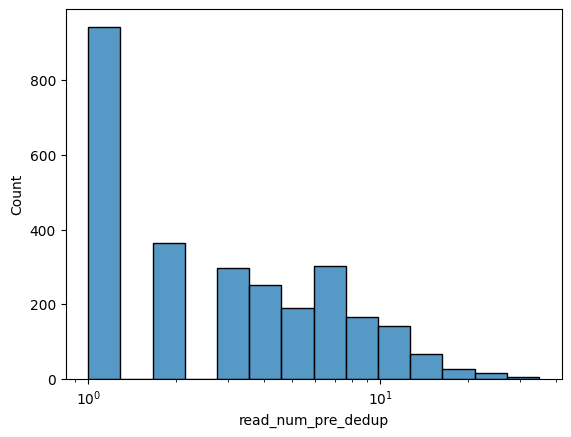

In [13]:
sns.histplot(res, x='read_num_pre_dedup', log_scale=True)

In [14]:
res.sort_values(by='read_num_post_dedup', ascending=False)

,umi,read_num_pre_dedup,read_num_post_dedup
244,b'TCAAAATCA',23,947.0
485,b'ACAAAATCA',26,128.0
361,b'GATACGTCA',31,117.0
298,b'AGCAAATCA',34,86.0
212,b'TGTCCTCCA',22,78.0
...,...,...,...
2751,b'AATGTATCA',2,NaN
2757,b'CGTCTATAA',1,NaN
2758,b'CGAACATCA',1,NaN
2761,b'CTTGTGTCA',1,NaN


In [15]:
res.sort_values(by='read_num_pre_dedup', ascending=False)

,umi,read_num_pre_dedup,read_num_post_dedup
169,b'AATATATCA',35,26.0
298,b'AGCAAATCA',34,86.0
361,b'GATACGTCA',31,117.0
179,b'TGATGCTCA',30,36.0
485,b'ACAAAATCA',26,128.0
...,...,...,...
2686,b'CTCGTGTCA',1,1.0
2687,b'AGCGCATCA',1,NaN
2688,b'CTTTGGTCA',1,1.0
2689,b'AGTGAATCA',1,1.0


In [16]:
res.groupby(by='read_num_post_dedup').count()

,umi,read_num_pre_dedup
read_num_post_dedup,,
1.0,830,830
2.0,298,298
3.0,242,242
4.0,191,191
5.0,164,164
6.0,124,124
7.0,112,112
8.0,63,63
9.0,65,65


<Axes: xlabel='read_num_post_dedup', ylabel='Count'>

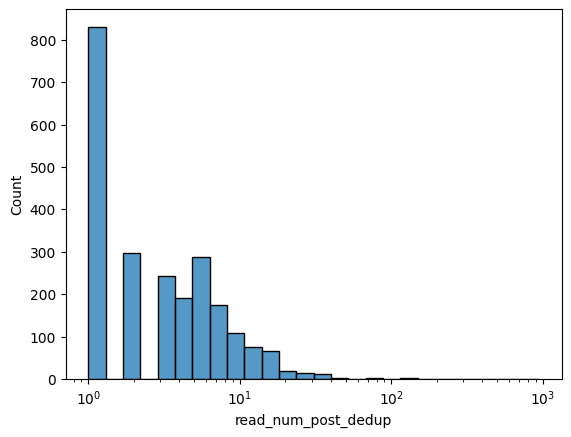

In [17]:
sns.histplot(res, x='read_num_post_dedup', log_scale=True)

In [18]:
res[res.read_num_pre_dedup > 1000]

,umi,read_num_pre_dedup,read_num_post_dedup


<Axes: xlabel='read_num_post_dedup', ylabel='Count'>

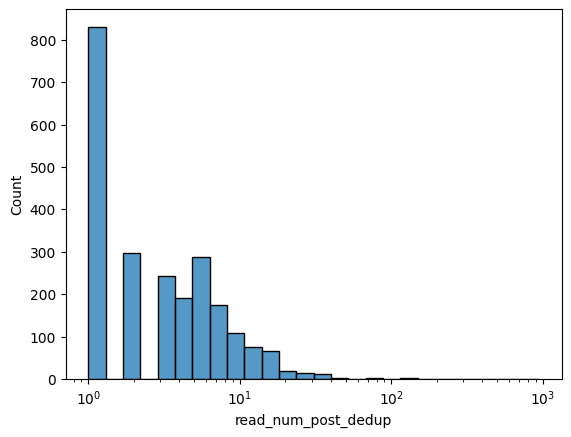

In [19]:
sns.histplot(res, x='read_num_post_dedup', log_scale=True)

In [20]:
res.groupby()

TypeError: You have to supply one of 'by' and 'level'

In [21]:
import logomaker
def plot_logo(clonotypes, ax):
    mat_df = logomaker.alignment_to_matrix(clonotypes)
    logomaker.Logo(mat_df, color_scheme='skylign_protein', ax=ax)

(-0.475, 11.475, 0.0, 11365.0)

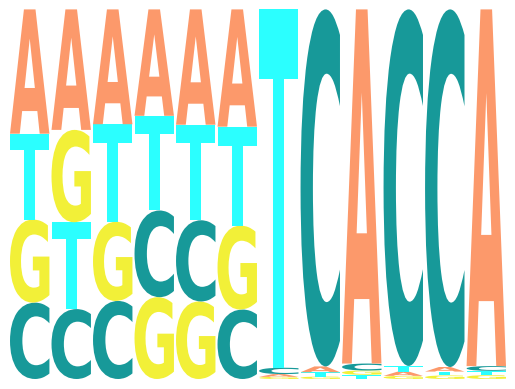

In [22]:
fig, ax = plt.subplots()
plot_logo([x[:12].decode('ascii') for x in sequences], 
         ax=ax)
plt.axis('off')

In [18]:
5

5

## reading initial data

In [18]:
'read_cluster_id', 'read_node_id', 'read_id', 'read_f_name', 'read_f_seq', 'read_f_qual', 'read_r_name', 'read_r_seq', 'read_r_qual'

('read_cluster_id',
 'read_node_id',
 'read_id',
 'read_f_name',
 'read_f_seq',
 'read_f_qual',
 'read_r_name',
 'read_r_seq',
 'read_r_qual')

In [29]:
def read_fastq_gz(fastq_file):
    sequences = []
    with gzip.open(fastq_file) as f:
        while header := f.readline().strip().decode("utf-8"):  # read header string
            if not header:
                break
            sequence = f.readline()
            _, _ = f.readline(), f.readline()
            sequences.append(sequence)
    return sequences

In [48]:
data = read_fastq_gz('../results/test_takara_2_pyumi.fastq.gz')

In [49]:
len(data)

250000

In [50]:
adapters = [x[:12].decode('ascii').strip() for x in data]

In [51]:
data[0]

b'ATGTCCGTTGTAGTACGGGGGGGGCGTCCCTCCTCCTCTGCTCCTGCTCACAGTGATCCTGATCTGGTAAAGCTCCCAGCCTGCCCTGCCCCTGCCAGGGGCACCAGGCTCCTCTTCTGGGTGGCCTTCTGGCTCCTGGGGGCAGATCAC\n'

In [52]:
adapters[0]

'ATGTCCGTTGTA'

In [53]:
len(adapters[0])

12

(-0.475, 11.475, 0.0, 250000.0)

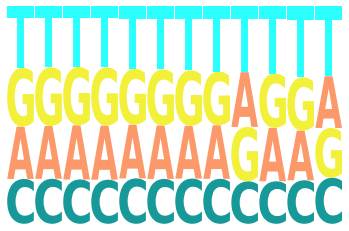

In [54]:
fig, ax = plt.subplots()
plot_logo(adapters, ax=ax)
plt.axis('off')

In [44]:
len(sequences[0])

152

In [45]:
counters = []

In [46]:
pd.Series([len(x) for x in sequences]).value_counts()

152    145130
150     51251
151     35343
149     10295
148      1177
        ...  
50          3
57          2
38          1
41          1
60          1
Name: count, Length: 111, dtype: int64

In [47]:
for i in range(152):
    counters.append(Counter([x[i] for x in sequences]))

IndexError: index out of range